In [3]:
!pip3 install xgboost

     |████████████████████████████████| 127.6 MB 17 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
  
%matplotlib inline

# my utils
from supervised_utils import *

# XGBOOST
import xgboost as xgb

# AWS boto/sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [5]:
mailout_joint_dataset_imputed_df = pd.read_csv("../arvato_data_processed/MAILOUTimputed.csv", index_col='LNR')

from sklearn.preprocessing import MinMaxScaler

MMS = MinMaxScaler()

mailout_joint_dataset_imputed_df = pd.DataFrame(MMS.fit_transform(mailout_joint_dataset_imputed_df), index = mailout_joint_dataset_imputed_df.index, columns = mailout_joint_dataset_imputed_df.columns)
mailout_joint_dataset_imputed_df

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,D19_BANKEN_DIREKT_RZ,D19_BANKEN_GROSS_RZ,...,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0
LNR,,,,,,,,,,,,,,,,,,,,,
1763,0.034247,0.011675,0.077424,0.034667,0.009540,0.666667,0.444444,0.523810,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1771,0.002283,0.011675,0.117536,0.002667,0.009540,0.666667,0.444444,0.428571,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1776,0.000000,0.014442,0.037312,0.002667,0.009540,0.000000,0.111111,0.095238,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1460,0.009132,0.011675,0.117536,0.010667,0.009540,0.166667,0.111111,0.095238,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1783,0.121005,0.011675,0.077424,0.117333,0.009540,0.500000,0.666667,0.619048,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67615,0.015549,0.012992,0.049954,0.017238,0.010107,0.666667,0.333333,0.380952,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67938,0.004566,0.011675,0.077424,0.005333,0.009540,0.833333,0.555556,0.380952,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67942,0.002283,0.011675,0.157648,0.002667,0.009540,0.833333,0.333333,0.285714,0.857143,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
train = mailout_joint_dataset_imputed_df[mailout_joint_dataset_imputed_df['dataset']==1]
train_labels = train['RESPONSE']
train = train.drop('dataset',axis='columns') 
train = train.drop('RESPONSE',axis='columns') 

In [16]:
test = mailout_joint_dataset_imputed_df[mailout_joint_dataset_imputed_df['dataset']==0]
 
test = test.drop('dataset',axis='columns') 
test = test.drop('RESPONSE',axis='columns')

# Model 1: XGBoost initial model


In [ ]:
bayes_xgb = xgb.XGBClassifier(base_score=0.5, 
                              booster='gbtree', 
                              colsample_bylevel=1,
                              colsample_bytree=0.7, 
                              eval_metric='auc', 
                              gamma=1.0,
                              learning_rate=0.015, 
                              max_delta_step=0, 
                              max_depth=7,
                              min_child_weight=1, 
                              missing=None, # I have imputed missing values
                              n_estimators=236, 
                              n_jobs=-1,
                              nthread=-1, 
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1e-09, 
                              reg_lambda=1, 
                              scale_pos_weight=1, 
                              seed=None,
                              silent=1, 
                              subsample=0.5)

In [10]:
%%time
bayes_xgb.fit(train, train_labels)

[17:57:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 3min 47s, sys: 286 ms, total: 3min 48s
Wall time: 3min 48s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=1.0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.015, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=236, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, objective='binary:logistic',
              random_state=0, reg_alpha=1e-09, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, ...)

In [52]:
def xgb_important_features(model, feature_names,top=10,width=10,height=6):
    
    f_imp = pd.DataFrame(model.feature_importances_*100,index=feature_names)
    f_imp.columns = ['Importance']
    f_imp = f_imp.sort_values('Importance',ascending=False)
    
    f_imp_top = f_imp[:top]
    f_imp_top = f_imp_top.sort_values('Importance',ascending=True)
    
    plt.figure(figsize=(width, height))
    ax = plt.subplot( )
 
    
    ax.barh(y =f_imp_top.index, width =f_imp_top['Importance'])
    
    return(f_imp)



,Importance
D19_SOZIALES_1.0,1.042657
D19_KONSUMTYP_MAX_2,0.388166
CJT_KATALOGNUTZER_4.0,0.383587
SHOPPER_TYP_0.0,0.355154
GFK_URLAUBERTYP_3.0,0.343839
...,...
PRAEGENDE_JUGENDJAHRE_15.0,0.000000
UMFELD_JUNG_1.0,0.000000
PRAEGENDE_JUGENDJAHRE_14.0,0.000000
PRAEGENDE_JUGENDJAHRE_13.0,0.000000


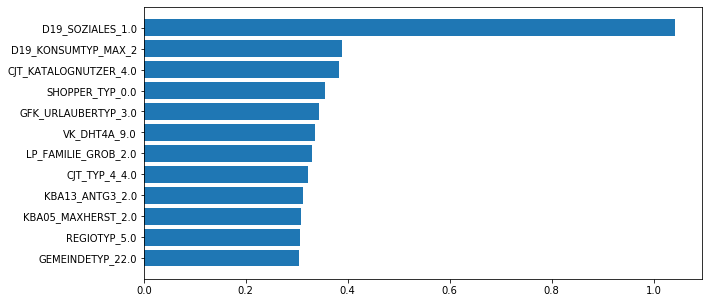

In [85]:
importance = xgb_important_features(bayes_xgb, train.columns,top =12, width=10, height=5 )
importance

## Predict test

In [15]:

test_preds = bayes_xgb.predict_proba(test) 
# predict_proba - predict the probability of each data example being of a given class.


NameError: name 'bayes_xgb' is not defined

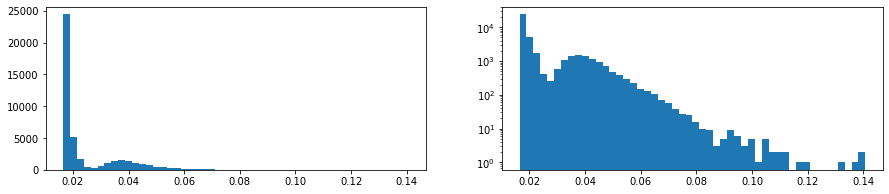

In [83]:
# Probability of being influences by marketing campaign.
# Most of examples will have small probability
fig, axs = plt.subplots(1,2,figsize=(15,3))
axs[0].hist(test_preds[:,1],bins = 50, log = False)
axs[1].hist(test_preds[:,1],bins = 50, log = True)
plt.show()

In [84]:
test_preds = pd.DataFrame({'LNR':test.index ,'RESPONSE':  test_preds[:,1] })
test_preds.to_csv("../submissions/xgboost_init.csv",sep=",", index=False)
test_preds

,LNR,RESPONSE
0,1754,0.042130
1,1770,0.037100
2,1465,0.016507
3,1470,0.016699
4,1478,0.019569
...,...,...
42828,67615,0.017513
42829,67938,0.017316
42830,67942,0.039059
42831,67949,0.047715


## Model 1 test score: `0.77172`

---
# Hyperparameter tuning

Initial "guessed" model is already doing better than linear learner (on `Kaggle`). Here I will

## Train/validation split

I am going to split my train dataset in order to address the target metric `validation:auc` of our xgboost model. 

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train, train_labels, train_size=0.925)

(array([39245.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   494.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

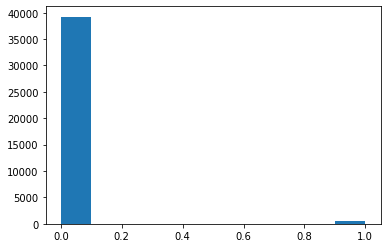

In [12]:
plt.hist(Y_train)

(array([0., 1.]), array([3185,   38]))


(array([3185.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          38.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

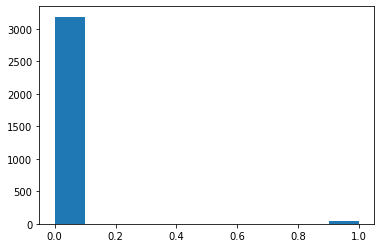

In [13]:
print(np.unique(Y_test,return_counts=True))
plt.hist(Y_test)

## Upload to S3

In [17]:
# Test - without true labels (which we don't have!)
import os
data_dir = "../arvato_data_processed/xgboost"

test.to_csv( os.path.join(data_dir+ "test.csv"), header=False, index=False)
# Train/validation
pd.concat([Y_train, X_train], axis=1).to_csv(  os.path.join(data_dir+ "train.csv"), header=False, index=False)
pd.concat([Y_test, X_test], axis=1).to_csv(  os.path.join(data_dir+ "validation.csv"), header=False, index=False)


In [18]:

prefix = 'arvato-xgboost-tuning'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Define an initial model

In [19]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


## Hyperparameter tuning

In [20]:
xgb.set_hyperparameters(base_score=0.5,  # global bias
                              booster='gbtree', 
                              colsample_bylevel=1, # Subsample ratio of columns for each level.
                              colsample_bytree=0.9, # Subsample ratio of columns when constructing each tree.
                              eval_metric='auc', 
                              gamma=1.0,
                              eta=0.015, 
                              max_delta_step=0, 
                              max_depth=7,
                              min_child_weight=1, 
                              missing=None, # I have imputed missing values
                              n_estimators=250, 
                              n_jobs=-1,
                              objective='binary:logistic', 
                              random_state=0,
                              reg_alpha=1e-09, 
                              reg_lambda=1e-5, 
                              scale_pos_weight=1, 
                              seed=123,
                              silent=1, 
                              subsample=0.95,
                              num_round=250, # max number of rounds 
                         early_stopping_rounds=10, #  Activates early stopping. Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training
)

In [21]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 50, # The total number of models to train
                                               max_parallel_jobs = 10, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.01, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                                    'colsample_bytree': ContinuousParameter(0.5, 1),
                                                   'alpha' : ContinuousParameter(1e-09, 1e-1),
                                                   'lambda' : ContinuousParameter(1e-09, 1e-1)
                                               })

In [22]:

# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [23]:
%%time
xgb_hyperparameter_tuner.wait()

................................................................................................................................................................................................................................................!
CPU times: user 1.48 s, sys: 97.2 ms, total: 1.58 s
Wall time: 20min 15s


## Select the best model

In [24]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-200623-1541-044-2f6b235a'

In [25]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-06-23 15:58:52 Starting - Preparing the instances for training
2020-06-23 15:58:52 Downloading - Downloading input data
2020-06-23 15:58:52 Training - Training image download completed. Training in progress.
2020-06-23 15:58:52 Uploading - Uploading generated training model
2020-06-23 15:58:52 Completed - Training job completedArguments: train
[2020-06-23:15:58:19:INFO] Running standalone xgboost training.
[2020-06-23:15:58:19:INFO] Setting up HPO optimized metric to be : auc
[2020-06-23:15:58:19:INFO] File size need to be processed in the node: 138.06mb. Available memory size in the node: 8482.9mb
[2020-06-23:15:58:19:INFO] Determined delimiter of CSV input is ','
[15:58:19] S3DistributionType set as FullyReplicated
[15:58:20] 32461x809 matrix with 26260949 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-23:15:58:20:INFO] Determined delimiter of CSV input is ','
[15:58:20] S3DistributionType set as FullyReplicated
[15:58:20] 2633x809 ma

## Predict the test

In [26]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [27]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [28]:
xgb_transformer.wait()

.....................Arguments: serve
[2020-06-23 16:04:44 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-23 16:04:44 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-23 16:04:44 +0000] [1] [INFO] Using worker: gevent
[2020-06-23 16:04:44 +0000] [39] [INFO] Booting worker with pid: 39
[2020-06-23 16:04:44 +0000] [40] [INFO] Booting worker with pid: 40
[2020-06-23 16:04:44 +0000] [41] [INFO] Booting worker with pid: 41
[2020-06-23 16:04:44 +0000] [42] [INFO] Booting worker with pid: 42
[2020-06-23:16:04:44:INFO] Model loaded successfully for worker : 41
[2020-06-23:16:04:44:INFO] Model loaded successfully for worker : 39
[2020-06-23:16:04:44:INFO] Model loaded successfully for worker : 40
[2020-06-23:16:04:44:INFO] Model loaded successfully for worker : 42
[2020-06-23:16:05:09:INFO] Sniff delimiter as ','
[2020-06-23:16:05:09:INFO] Determined delimiter of CSV input is ','
[2020-06-23:16:05:09:INFO] Sniff delimiter as ','
[2020-06-23:16:05:09:INFO] Determined delimit

In [29]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-west-2-567552853371/xgboost-200623-1541-044-2f6b235a-2020-06-23-16-01-25-272/test.csv.out to ../arvato_data_processed/xgboost/test.csv.out


In [30]:
!cat $data_dir/test.csv.out | wc -l

42833


In [31]:
test_preds = pd.read_csv(os.path.join(data_dir,"test.csv.out"),header=None)
test_preds.columns =[ 'RESPONSE']
test_preds['LNR'] = test.index.values
test_preds = test_preds[['LNR','RESPONSE']]

test_preds.to_csv("../submissions/xgboost_optimized.csv",sep=",", index=False)